# Welcome to torch study
## 1월 2주차 : Convolutional Sentiment Analysis
1) 원래 코드에 주석 달기<br>
2) 새로운 데이터셋 적용하여 돌려보기<br>
3) 구현 시 주의해야할 사항 미리 생각해오기<br>

In [1]:
import torch
from torch.utils.data import DataLoader 
import torchtext
from torchtext import data
from torchtext.data import Dataset, Example, TabularDataset, Iterator
import random
import numpy as np
import pandas as pd

In [2]:
torch.__version__, torchtext.__version__

('1.7.1', '0.8.1')

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

https://github.com/yoonkim/CNN_sentence 레파지토리 clone 한 경로 

In [10]:
path = '/home/long8v/CNN_sentence'

## Data Loading

In [11]:
with open('{}/rt-polarity.pos'.format(path), 'rb') as f:
    pos = f.readlines()

In [12]:
with open('{}/rt-polarity.neg'.format(path), 'rb') as f:
    neg = f.readlines()

## Data Preprocessing 
1) label을 tuple로 묶은 뒤에 csv파일로 export<br>
2) TEXT, LABEL을 정의해주고 이를 fields로 정의<br>
3) TabularDataset으로 csv파일 import 해줌 <br>
4) train, valid, test으로 split함<br>
5) build_vocab 해줌 -> 더 알아보기 ㄱ. vectors가 진짜 되는건지? unk_init이 진짜 되는건지?<br>
6) Iterator로 batch로 묶어주기

In [13]:
dataset = [(p, 1) for p in pos] + [(n, 0) for n in neg]

In [14]:
pd.DataFrame(dataset).to_csv('train.csv', index=None)

In [15]:
TEXT = data.Field(tokenize = lambda e: e.split(), 
                  batch_first = True)
LABEL = data.LabelField(dtype = torch.float)
fields = [('text', TEXT), ('label', LABEL)]

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [16]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [17]:
dataset = TabularDataset('train.csv', fields=fields, format='csv')

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [18]:
train_data, test_data = dataset.split()
train_data, valid_data = train_data.split()

In [19]:
MAX_VOCAB_SIZE = np.inf

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:43, 2.14MB/s]                               
100%|█████████▉| 399999/400000 [00:11<00:00, 33384.36it/s]


In [20]:
train_iterator, valid_iterator, test_iterator = map(lambda e: Iterator(e, batch_size=BATCH_SIZE, device=device),
                                     (train_data, valid_data, test_data))

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [21]:
for data, label in train_iterator:
    print(data)
    print(data.shape)
    print(label)
    print(label.shape)
    break

tensor([[4548, 2858, 1850,  ...,    1,    1,    1],
        [  49,    8,   21,  ...,    1,    1,    1],
        [  49,   16,   56,  ...,    1,    1,    1],
        ...,
        [ 583,    6, 6881,  ...,    1,    1,    1],
        [ 654,    4,   60,  ...,    2,    5,    1],
        [  24,  266,    3,  ...,    1,    1,    1]])
torch.Size([64, 43])
tensor([0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        1., 1., 0., 0., 0., 0., 1., 1., 1., 1.])
torch.Size([64])


/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Build the Model

CNN은 보통 이미지에서 많이 사용된다. 이미지는 보통 가로, 세로로 2 차원이다.(RGB 차원은 추후에 논의). 그에 반해 text는 1차원이다. 하지만 우리는 단어를 word embedding을 통해 차원을 늘린다. 그래서 우리가 단어를 2차원으로 보는 이유다. 

우리는 [ n x emb_dim ]인 filter를 사용하게 된다. 이것은 n개의 연속적인 단어를 커버하고, 우리의 너비는 emb_dim이 되게된다. 두개의 단어를 한번에 보는 필터는(=bi-grams) [ 2 x emb_dim ] 필터가 될 것이다.
필터는 이미지의 아래로 내려가면서 bi-gram을 커버하고 결과가 계산된다. 결과의 output vector는 이미지의 높이 - 필터의 높이 + 1 만큼 되게 된다.

이 예시는 하나의 필터가 어떻게 계산하는지를 보여준다. 그러나 우리의 모델은 이러한 필터를 여러개 사용하게 된다. 주요 아이디어는 각각의 필터가 다른 피쳐를 뽑는다는 것이다. 우리의 모델에서는 다른 크기의 필터를 쓸 것이다. 높이 3, 4, 5의 필터를 각각 100개씩 사용할 것이다. 이를 통해 tri-gram, 4-gram, 5-gram을 사용하는 효과를 가졌으면 좋겠다.

다음 단계는 pooling을 하는 과정이다. 이것은 각각의 단어 벡터에서 평균을 구한 FastText와 비슷하다. 그러나 우리는 대신 max value를 구할 것이다. 

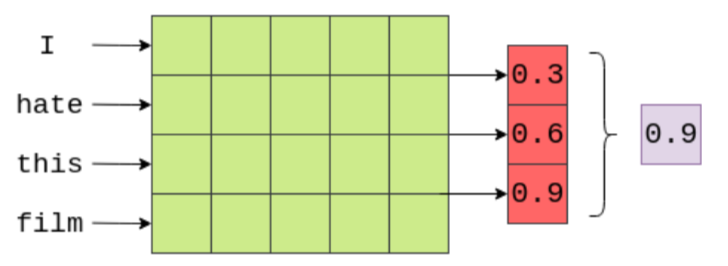

이 아이디어는 review의 감정을 결정하는데 가장 중요한 value를 뽑는다는 점이다. 우리의 모델은 3개의 다른 사이즈의 100개의 필터를 가지고 있으니 우리는 총 300개의 다른 n-grams를 가지게 된다. 우리는 이것을 concat해서 하나의 벡터로 만든 뒤에 감정을 예측하기 위해 linear layer 에 쏜다. 우리는 이 linear layer를 300개의 단서에 대한 weight를 주는 과정이라고 볼 수 있다.

### Implementation Details

nn.Conv2d를 사용할때 in_channels는 convoluional layer에 들어갈 이미지의 채널 개수를 뜻한다. 이미지에서는 보통 RGB channel이어서 3개이지만, 우리의 text는 singel channel이기 때문에 1이다. 

out_channels는 채널의 개수가 되고, kernel_size는 필터의 크기를 의미한다. 우리의 kernel_size는 [ n x emb_dim ]이 되고 n은 n-gram의 크기가 된다.

파이토치에서는 RNN은 batch dimension이 2번째 차원에 위치하길 원하지만, CNN은 batch dim이 첫번째로 와야 한다. 우리는 TEXT 필드에서 batch_fist = True 를 주었기 때문에 바꿀 필요는 없다. 실제로 텍스트 데이터는 채널 차원을 가지고 있지 않기 때문에 unsqueeze 함수를 만들어서 차원을 하나 만들어준다. 이는 우리가 앞으로 convolution layer에서 in_channels = 1 로 주는 이유가 되게 된다.



We then pass the tensors through the convolutional and pooling layers, using the `ReLU` activation function after the convolutional layers. Another nice feature of the pooling layers is that they handle sentences of different lengths. The size of the output of the convolutional layer is dependent on the size of the input to it, and different batches contain sentences of different lengths. Without the max pooling layer the input to our linear layer would depend on the size of the input sentence (not what we want). One option to rectify this would be to trim/pad all sentences to the same length, however with the max pooling layer we always know the input to the linear layer will be the total number of filters. **Note**: there an exception to this if your sentence(s) are shorter than the largest filter used. You will then have to pad your sentences to the length of the largest filter. In the IMDb data there are no reviews only 5 words long so we don't have to worry about that, but you will if you are using your own data.

Finally, we perform dropout on the concatenated filter outputs and then pass them through a linear layer to make our predictions.

##  `nn.Conv2d`

in_channels (int) – Number of channels in the input image -> 이미지의 channel, RGB 채널에선 3, Black-white면 1

out_channels (int) – Number of channels produced by the convolution -> 필터의 개수, 각 필터 output을 concat해서 결과 값의 dim이 됨

kernel_size (int or tuple) – Size of the convolving kernel -> 필터 크기

stride (int or tuple, optional) – Stride of the convolution. Default: 1

padding (int or tuple, optional) – Zero-padding added to both sides of the input. Default: 0

padding_mode (string, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'

dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1

groups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1

bias (bool, optional) – If True, adds a learnable bias to the output. Default: True

## `max_pool1d`
kernel_size – The size of the sliding window, must be > 0.

stride – The stride of the sliding window, must be > 0. Default value is kernel_size.

padding – Implicit negative infinity padding to be added on both sides, must be >= 0 and <= kernel_size / 2.

dilation – The stride between elements within a sliding window, must be > 0.

return_indices – If True, will return the argmax along with the max values. Useful for torch.nn.MaxUnpool1d later

ceil_mode – If True, will use ceil instead of floor to compute the output shape. This ensures that every element in the input tensor is covered by a sliding window.



In [22]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[0], embedding_dim)) 
        
        self.conv_1 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[1], embedding_dim))
        
        self.conv_2 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[2], embedding_dim))
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

Currently the `CNN` model can only use 3 different sized filters, but we can actually improve the code of our model to make it more generic and take any number of filters.

We do this by placing all of our convolutional layers in a  `nn.ModuleList`, a function used to hold a list of PyTorch `nn.Module`s. If we simply used a standard Python list, the modules within the list cannot be "seen" by any modules outside the list which will cause us some errors.


We can now pass an arbitrary sized list of filter sizes and the list comprehension will create a convolutional layer for each of them. Then, in the `forward` method we iterate through the list applying each convolutional layer to get a list of convolutional outputs, which we also feed through the max pooling in a list comprehension before concatenating together and passing through the dropout and linear layers.

In [23]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

We can also implement the above model using 1-dimensional convolutional layers, where the embedding dimension is the "depth" of the filter and the number of tokens in the sentence is the width.

We'll run our tests in this notebook using the 2-dimensional convolutional model, but leave the implementation for the 1-dimensional model below for anyone interested. 

In [24]:
class CNN1d(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

We create an instance of our `CNN` class. 

We can change `CNN` to `CNN1d` if we want to run the 1-dimensional convolutional model, noting that both models give almost identical results.

In [25]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

Checking the number of parameters in our model we can see it has about the same as the FastText model. 

Both the `CNN` and the `CNN1d` models have the exact same number of parameters.

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,718,301 trainable parameters


Next, we'll load the pre-trained embeddings

In [41]:
TEXT.vocab.vectors

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.3389,  0.2919,  0.2993,  ...,  0.2409,  0.2894, -0.6609],
        [ 0.5732, -1.0756, -0.1600,  ...,  0.4548,  0.2344,  0.0364],
        [-1.9586, -0.8252,  0.7357,  ..., -0.4683, -0.9213, -1.8672]])

# initialize하는 부분

In [47]:
len(TEXT.vocab.stoi)

24022

torch.Size([15977, 100])

In [44]:
pretrained_embeddings.shape

torch.Size([15977, 100])

## 없는 부분은 ,,?? unk token이 아닌 8천개는 ..?? 어디로감... ??
## vectors를 주면 잇는거가 위로 올라가고 나머지는 밑으로 깔리는건가??

In [42]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.3389,  0.2919,  0.2993,  ...,  0.2409,  0.2894, -0.6609],
        [ 0.5732, -1.0756, -0.1600,  ...,  0.4548,  0.2344,  0.0364],
        [-1.9586, -0.8252,  0.7357,  ..., -0.4683, -0.9213, -1.8672]])

In [74]:
a = nn.Embedding(999, 100)

In [82]:
a(torch.Tensor([998]).long())

tensor([[ 3.7968e-01, -3.6067e-01, -3.1896e-01, -2.6047e-01,  4.9872e-01,
         -9.5294e-01, -1.1359e+00, -2.5630e+00, -1.0632e+00,  4.4934e-01,
          1.9689e-01, -7.1556e-01, -1.1524e+00, -5.6907e-01,  3.7148e-01,
          4.3395e-01,  3.8550e-01, -4.7201e-01,  2.0590e+00,  4.2779e-01,
         -2.3480e+00,  4.6433e-01, -5.4954e-02, -9.8261e-01,  3.3519e-01,
          7.6828e-01,  1.0037e+00,  3.3785e-01,  6.1547e-01, -7.4358e-01,
          2.5064e-01, -2.4256e+00, -6.0385e-01,  8.9104e-01,  7.0511e-01,
          1.9384e+00,  4.9597e-01, -9.6941e-03,  1.6937e+00,  2.1961e-01,
         -2.6975e-01,  2.0366e-01, -7.3366e-01, -2.9865e-01,  2.6617e-01,
         -1.2881e+00, -1.5910e+00, -9.7948e-01,  1.4124e+00, -8.0440e-01,
          4.6586e-02,  3.4973e-01,  7.5777e-01,  8.0178e-03,  2.0759e+00,
         -1.3325e-01,  1.3574e+00,  1.4187e+00,  1.1619e+00,  7.1088e-01,
          1.1936e+00, -3.0815e-01,  1.6093e+00,  1.5148e+00, -5.8613e-01,
          3.7833e-01, -3.6349e-01,  7.

Then zero the initial weights of the unknown and padding tokens.

In [28]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Train the Model

Training is the same as before. We initialize the optimizer, loss function (criterion) and place the model and criterion on the GPU (if available)

In [29]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [30]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, max_pool1d torch.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

We define a function for training our model...

**Note**: as we are using dropout again, we must remember to use `model.train()` to ensure the dropout is "turned on" while training.

In [31]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We define a function for testing our model...

**Note**: again, as we are now using dropout, we must remember to use `model.eval()` to ensure the dropout is "turned off" while evaluating.

여태 `model.eval()`하면 `with torch.no_grad()` 되는 줄 알았음...!! 둘 다 해야 맞는거구나

In [32]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Let's define our function to tell us how long epochs take.

In [33]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model...

In [34]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 0.677 | Train Acc: 57.31%
	 Val. Loss: 0.627 |  Val. Acc: 66.81%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.573 | Train Acc: 70.97%
	 Val. Loss: 0.561 |  Val. Acc: 70.83%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.446 | Train Acc: 80.10%
	 Val. Loss: 0.523 |  Val. Acc: 73.25%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.331 | Train Acc: 86.55%
	 Val. Loss: 0.511 |  Val. Acc: 74.28%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.233 | Train Acc: 91.36%
	 Val. Loss: 0.531 |  Val. Acc: 74.32%


We get test results comparable to the previous 2 models!

In [35]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.507 | Test Acc: 75.21%


## User Input

And again, as a sanity check we can check some input sentences

**Note**: As mentioned in the implementation details, the input sentence has to be at least as long as the largest filter height used. We modify our `predict_sentiment` function to also accept a minimum length argument. If the tokenized input sentence is less than `min_len` tokens, we append padding tokens (`<pad>`) to make it `min_len` tokens.

In [37]:
tokenizer = lambda e: e.split()

def predict_sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok for tok in tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

An example negative review...

In [38]:
predict_sentiment(model, "This film is terrible")

0.5251014232635498

An example positive review...

In [39]:
predict_sentiment(model, "This film is great")

0.853912353515625

# 모델과 논문이 다른 것
- ReLU layer 
- Optimizer 
- preprocessing : clean_ 어쩌구 
- train test split :
- pretrained word2vec : 

## 어떻게 구현할지 생각해오기 
- word2vec model : nn.Embedding에서 weight를 주기
- word2vec에 없는 단어는 랜덤 vector로 주어져야함 (Words not present in the set of pre-trained words are initalized randomly) : Field로 stoi 먼저 구축한다음에 vocab에 없는 것들을 그냥 랜덤으로 줄 수 있을듯..!..! 
 -> 아마 nn.Embedding을 초기화하는 클래스 내 함수를 정의하는게 좋을듯!
- CNN - static : `nn.Embedding(10, 5).requires_grad_(False)`
- CNN - mutli-channel : 음.................nn.Embedding을 torch.Tensor로 싼 다음에 requires_grad을 하나는 주고 하나는 안주고 한다음에 input_dim을 2로 하는 CNN을 하는게 맞을까?
- L2 norm weight : 아직 모르겠음..윤킴 코드 보자
- CNN max-over-time-pooling : reference code 그대로 하면 됨
- adadelta : `torch.optim.Adadelta(params, lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)`